## DGMD S-17 Robotics, Autonomous Vehicles, Drones, and Artificial Intelligence

### Object Detection, Depth Perception and Adaptive Navigation with a Tello Drone

### Group Members: Ryan Abbate, Eumar Assis, Muthukaruppan (Muthu) Annamalai

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

## Load Telemetry data frame

In [2]:
df = pd.read_csv("./assets/telemetry.csv")
df_c = df[df['Model'] == 'DepthPerception'][['log_time', 'confidence']].rename(columns={'log_time': 'log_time', 'confidence': 'total_intensity'})
df = pd.merge(df, df_c, on='log_time')

print(df.columns)
df.describe()

Index(['log_time', 'Model', 'confidence', 'detected bounding box width',
       'detected bounding box height', 'img xcenter', 'img ycenter',
       'model output xcenter', 'model output ycenter',
       'height (distance to floor)', 'is_flying', 'total_intensity'],
      dtype='object')


,confidence,detected bounding box width,detected bounding box height,img xcenter,img ycenter,model output xcenter,model output ycenter,height (distance to floor),total_intensity
count,3.760000e+02,253.000000,253.000000,491.0,491.0,253.000000,253.000000,491.000000,4.910000e+02
mean,7.456119e+07,488.560087,496.527158,480.0,360.0,302.810243,181.818371,0.244399,2.278962e+08
std,1.086403e+08,244.024276,182.939030,0.0,0.0,195.658168,169.207741,12.017901,3.211616e+07
min,2.806100e-01,89.000000,90.000000,480.0,360.0,5.500000,-23.000000,-100.000000,1.591261e+08
25%,7.909167e-01,256.000000,355.000000,480.0,360.0,145.500000,25.000000,0.000000,2.053526e+08
50%,9.076798e-01,460.441925,519.000000,480.0,360.0,227.500000,113.000000,0.000000,2.276213e+08
75%,2.043804e+08,712.000000,685.000000,480.0,360.0,486.823364,360.000000,0.000000,2.526919e+08
max,2.925508e+08,939.234924,720.000000,480.0,360.0,811.901123,524.035156,80.000000,2.925508e+08


## 1. Comparing Azure vs. YOLO 

Comparing people detector models

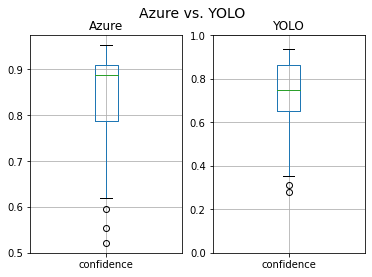

In [3]:
#Get filtered data frames
azure_df = df[df['Model'] =='AzureObjectDetector'] 

yolo_df = df[df['Model'] == 'YOLOObjectDetector']

# Plot two histograms side by side using Matplotlib
fig, axes = plt.subplots(1, 2)

fig.suptitle('Azure vs. YOLO', fontsize=14)

azure_df.boxplot('confidence', ax=axes[0])
axes[0].set_title('Azure')
yolo_df.boxplot('confidence', ax=axes[1])
axes[1].set_title('YOLO')
plt.show()



## 2. Comparing YOLO Face vs. YOLO

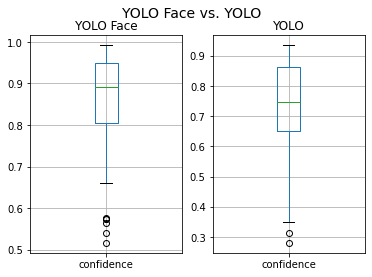

In [13]:
#Get filtered data frames
yolo_face_df = df[df['Model'] == 'YOLOFaceDetector']

# Plot two histograms side by side using Matplotlib
fig, axes = plt.subplots(1, 2)

fig.suptitle('YOLO Face vs. YOLO', fontsize=14)
yolo_face_df.boxplot('confidence', ax=axes[0])
axes[0].set_title('YOLO Face')
yolo_df.boxplot('confidence', ax=axes[1])
axes[1].set_title('YOLO')
plt.show()

## 3. Model Accuracy Histogram

Comparing accuracy of 1. YOLO, 2. YOLO Face & 3. Azure Models

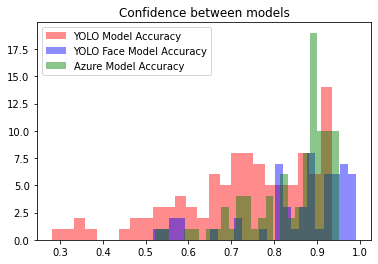

In [15]:
# plotting two histograms on the same axis
plt.hist(yolo_df['confidence'], bins=25, alpha=0.45, color='red')
plt.hist(yolo_face_df['confidence'], bins=25, alpha=0.45, color='blue')
plt.hist(azure_df['confidence'], bins=25, alpha=0.45, color='green')

plt.title("Confidence between models")
plt.legend(['YOLO Model Accuracy',
            'YOLO Face Model Accuracy',
            'Azure Model Accuracy'])
  
plt.show()

## 4. Finding person distance from camera

Comparing Computer Vision bounding boxes vs. density

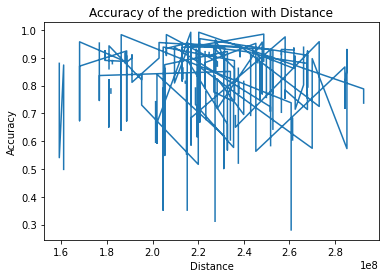

In [11]:
# Plotting the Graph
df_det = df[df['Model'] != 'DepthPerception']
plt.plot(df_det.total_intensity, df_det.confidence)
plt.title("Accuracy of the prediction with Distance")
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.show()